In [1]:
##
## The approach here is through two stages.
##
## 1. Transform the image patches to be more amenable to classification.
## 2. Use the refined features to predict the scores.
##
## Patch extraction is derived from https://www.kaggle.com/harupy/visualization-panda-16x128x128-tiles
## (which is in turn derived from lafoss)
##
## Classifier is derived from https://www.kaggle.com/prateekagnihotri/efficientnet-keras-train-qwk-loss-augmentation
## except that we don't use a pre-existing network (doesn't seem to make sense)
##

import os
from functools import reduce

import pandas as pd
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

INPUT_DIR = "./input/prostate-cancer-grade-assessment"
TRAIN_DIR = f"{INPUT_DIR}/train_images"
MASK_DIR = f"{INPUT_DIR}/train_label_masks"



N = 16



def extract_patches(img,patch_size):
    """
    extracts all patches from an image
    :returns: A list of `skimage.image` objects.
    """
    size = patch_size

    H, W = img.shape[:2]
    pad_h = (size - H % size) % size
    pad_w = (size - W % size) % size

    print("pad_h:", pad_h)
    print("pad_w", pad_w)

    padded = np.pad(
        img,
        [[pad_h // 2, pad_h - pad_h // 2],
         [pad_w // 2, pad_w - pad_w // 2],
         [0, 0]],
        constant_values = WHITE[0],
    )

    n_rows = padded.shape[0] // size
    n_cols = padded.shape[1] // size


    print("n_rows :", n_rows)
    print("n_cols :", n_cols)
    print("N_TILES:", n_rows * n_cols)

    reshaped = padded.reshape(
        padded.shape[0] // size,
        size,
        padded.shape[1] // size,
        size,
        3,
    )
    transposed = reshaped.transpose(0, 2, 1, 3, 4)
    tiles = transposed.reshape(-1, size, size, 3)

    print("reshaped.shape  :", reshaped.shape)
    print("transposed.shape:", transposed.shape)
    print("tiles.shape     :", tiles.shape)

    sums = tiles.reshape(tiles.shape[0], -1).sum(axis=-1)
    tiles_selected = np.argsort(sums)[:N]

    return padded,tiles_selected, sums


pad_h: 80
pad_w 64
n_rows : 15
n_cols : 14
N_TILES: 210
reshaped.shape  : (15, 128, 14, 128, 3)
transposed.shape: (15, 14, 128, 128, 3)
tiles.shape     : (210, 128, 128, 3)


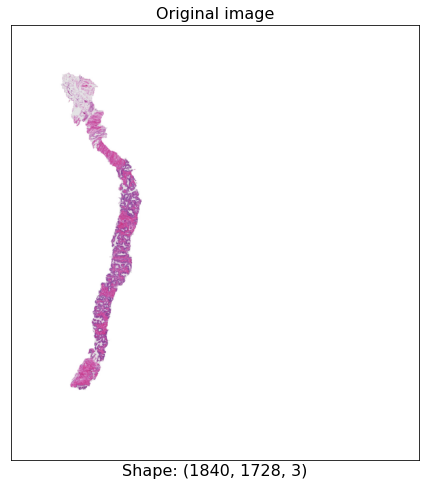

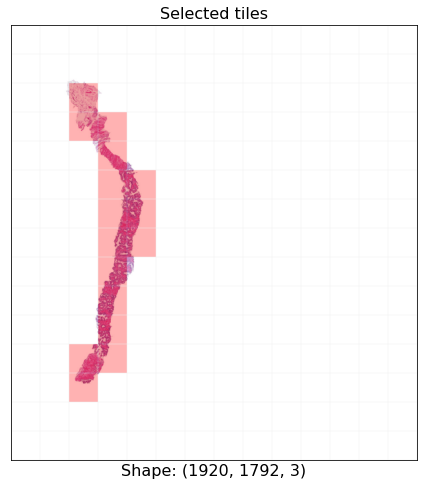

In [2]:
# wrapper to test patch extractor

SIZE = 128

BLACK = (0,) * 3
GRAY = (200,) * 3
WHITE = (255,) * 3
RED = (255, 0, 0)

def merge_tiles(tiles, funcs=None):
    """
    If `funcs` specified, apply them to each tile before merging.
    """
    return np.vstack([
        np.hstack([
            reduce(lambda acc, f: f(acc), funcs, x) if funcs else x
            for x in row
        ])
        for row in tiles
    ])


def draw_borders(img):
    """
    Put borders around an image.
    """
    ret = img.copy()
    ret[0, :] = GRAY   # top
    ret[-1, :] = GRAY  # bottom
    ret[:, 0] = GRAY   # left
    ret[:, -1] = GRAY  # right
    return ret


def fill_tiles(tiles, fill_func):
    """
    Fill each tile with another array created by `fill_func`.
    """
    return np.array([[fill_func(x) for x in row] for row in tiles])


def make_patch_func(true_color, false_color):
    def ret(x):
        """
        Returns a color patch. The color will be `true_color` if `x` is True otherwise `false_color`.
        """
        color = true_color if x else false_color
        return np.tile(color, (SIZE, SIZE, 1)).astype(np.uint8)

    return ret


def imshow(
    img,
    title=None,
    show_shape=True,
    figsize=(8, 8)
):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.grid("off")
    ax.set_xticks([])
    ax.set_yticks([])

    if show_shape:
        ax.set_xlabel(f"Shape: {img.shape}", fontsize=16)

    if title:
        ax.set_title(title, fontsize=16)

    return ax

def imread(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"No such file or directory: '{path}'")

    return skimage.io.MultiImage(path)


img_id = '0005f7aaab2800f6170c399693a96917'
img_org = imread(os.path.join(TRAIN_DIR, f"{img_id}.tiff"))[-1]

imshow(img_org, "Original image")

PATCH_SIZE = 128


padded, tiles, sums = extract_patches(img_org,PATCH_SIZE)

N_ROWS = padded.shape[0] // SIZE
N_COLS = padded.shape[1] // SIZE

mask = np.isin(np.arange(len(sums)), tiles).reshape(N_ROWS,N_COLS)
mask = fill_tiles(mask, make_patch_func(RED, WHITE))
mask = merge_tiles(mask, [draw_borders])

with_mask = np.ubyte(0.7 * padded + 0.3 * mask)

imshow(with_mask, "Selected tiles")



In [13]:
##
## try and compress 128 x 128 patches to 16 x 16, we use this later rather than try to feed huge images to
## a network.
##
## train the autoencoder on about 1000 patches
##

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

##
## need to train both encoder and decoder - only use the encoder later to compress the images
##

In [ ]:
##
## use compressed version to classify images - it doesn't make sense to retrain from a visually trained network
## as the new inputs don't look visual.
##
##
import os
import cv2
import time
import skimage.io
import numpy as np
import pandas as pd
import imgaug as ia
from PIL import Image
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
import efficientnet.keras as efn
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras import Model
import keras.backend as K
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.applications.nasnet import  preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



In [ ]:
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tiff', '')

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def get_image(img_name):
    data_dir = '../input/prostate-cancer-grade-assessment/train_images'
    img_path = os.path.join(data_dir, f'{img_name}.tiff')
    img = skimage.io.MultiImage(img_path)
    img = cv2.resize(img[-1], (256,256))
    return img

def data_gen(list_files, id_label_map, batch_size, augment=False):
    seq = get_seq()
    while True:
        shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [get_image(x) for x in batch]
            Y = np.zeros((len(batch),6))
            for i in range(len(batch)):
                Y[i,id_label_map[get_id_from_file_path(batch[i])]] = 1.0
            if augment:
                X = seq.augment_images(X)
            X = [preprocess_input(x) for x in X]

            yield np.array(X), np.array(Y)


In [ ]:
def quadratic_kappa_coefficient(y_true, y_pred):
    y_true = K.cast(y_true, "float32")
    n_classes = K.cast(y_pred.shape[-1], "float32")
    weights = K.arange(0, n_classes, dtype="float32") / (n_classes - 1)
    weights = (weights - K.expand_dims(weights, -1)) ** 2

    hist_true = K.sum(y_true, axis=0)
    hist_pred = K.sum(y_pred, axis=0)

    E = K.expand_dims(hist_true, axis=-1) * hist_pred
    E = E / K.sum(E, keepdims=False)

    O = K.transpose(K.transpose(y_true) @ y_pred)  # confusion matrix
    O = O / K.sum(O)

    num = weights * O
    den = weights * E

    QWK = (1 - K.sum(num) / K.sum(den))
    return QWK

def quadratic_kappa_loss(scale=2.0):
    def _quadratic_kappa_loss(y_true, y_pred):
        QWK = quadratic_kappa_coefficient(y_true, y_pred)
        loss = -K.log(K.sigmoid(scale * QWK))
        return loss

    return _quadratic_kappa_loss

In [ ]:
labeled_files = pd.read_csv("../input/prostate-cancer-grade-assessment/train.csv").image_id.values
test_files = pd.read_csv("../input/prostate-cancer-grade-assessment/test.csv").image_id.values

train, val = train_test_split(labeled_files, test_size=0.1, random_state=101010)



In [ ]:
##
## image input is a list of 16 patches compressed by the encoder
##

I = Input((256,256,3))
efnb3 = efn.EfficientNetB3(weights = None, include_top = False, input_tensor = I, pooling = 'avg', classes = None)
for layer in efnb3.layers:
    layer.trainable = True
x = Dropout(0.5)(efnb3.output)
x = Dense(64, activation='relu')(x)
x = Dense(6,activation='softmax')(x)

model = Model(inputs = efnb3.input, outputs = x)

model.compile(optimizer=Adam(1e-4), loss=quadratic_kappa_loss(scale=6.0), metrics=['acc',quadratic_kappa_coefficient])
# model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['acc'])
# model.summary()

check_point = ModelCheckpoint('./model.h5',monitor='val_loss',verbose=True, save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1)



In [ ]:
history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=15, verbose=1,
    callbacks=[check_point,early_stop,reduce_lr],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)

In [ ]:
data_dir = '../input/prostate-cancer-grade-assessment/test_images'
sample_submission = pd.read_csv('../input/prostate-cancer-grade-assessment/sample_submission.csv')
# data_dir = '../input/prostate-cancer-grade-assessment/train_images'
# sample_submission = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv').head(50)

test_images = sample_submission.image_id.values
labels = []

try:
    for image in tqdm(test_images):
        img = get_image(image, data_dir)
        preds = TTA(img)
        label = post_process(preds)
        labels.append(label)
    sample_submission['isup_grade'] = labels
except:
    print('Test dir not found')

sample_submission['isup_grade'] = sample_submission['isup_grade'].astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()